In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import AveragePooling1D, Activation, Flatten, Dense
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers import GlobalAveragePooling1D, UpSampling1D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD, Adam, Nadam, Adamax
from keras.layers.normalization import BatchNormalization
import keras.backend as K
from data_in_2s import data_in, normali
from modify_new import modify_model
from orignal_model import ori_model
#from tqdm import tqdm
#from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
num_test = 1
X_train, y_train = data_in(num_test)

In [3]:
#Nomalization
y_train = (y_train-50)/150
#X_train = normali(X_train)
print('Shape of X_train is: ' + str(X_train.shape))
print('Shape of y_train is: ' + str(y_train.shape))

Shape of X_train is: (6394, 1000, 5)
Shape of y_train is: (6394, 1)


In [4]:
#Import and Split test data

name_x = 'Training_data/DATA_%.2d_TYPE02.mat'%num_test
in_tem_x = sio.loadmat(name_x)['sig']
in_tem_x = in_tem_x.T

name_y = 'Training_data/DATA_%.2d_TYPE02_BPMtrace.mat'%num_test
in_tem_y = sio.loadmat(name_y)['BPM0']

X_test_tem = np.zeros((in_tem_y.shape[0]*2, 125*8, 5))

k = 0

for j in range(in_tem_y.shape[0]*2-1):
	X_test_tem[j, :, :] =  in_tem_x[k:(k+125*8), 1:]
	k += 125

tem_y = np.zeros((in_tem_y.shape[0]*2, 1))
index = [a*2 for a in range(in_tem_y.shape[0])]
tem_y[index] = in_tem_y

for b in range(tem_y.shape[0]-1):
	if tem_y[b] == 0:
		tem_y[b] = (tem_y[b-1] + tem_y[b+1])/2.

y_test = tem_y[:-1, :]
X_test = X_test_tem[:-1, :, :]

y_test = (y_test-50)/150
#X_test = normali(X_test)

print('The shape of X_test is: ' + str(X_test.shape))
print('The shape of y_test is: ' + str(y_test.shape))

The shape of X_test is: (295, 1000, 5)
The shape of y_test is: (295, 1)


In [5]:
X_train_PPG = X_train[:, :, :2]
X_train_acc = X_train[:, :, 2:]

Heart rate is: [ 149.18165]


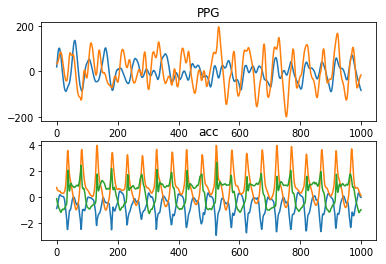

In [6]:
num_in = 1700
print('Heart rate is: ' + str(y_train[num_in]*150+50))
plt.subplot(211)
plt.plot(X_train_PPG[num_in, :, :])
plt.title('PPG')
plt.subplot(212)
plt.plot(X_train_acc[num_in, :, :])
plt.title('acc')
plt.show()

In [7]:
fir_model = ori_model((1000, 5), 16)

/media/zhuolun/DATA/Project/Atheros-CSI-Tool-UserSpace-APP/recvCSI/Xiaoshi/Xiong/augment  (1)/augment /orignal_model.py:199: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  model = Model(input=inputs, output=output)


In [8]:
optm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
fir_model.compile(loss= "mse", 
              optimizer=optm, 
              metrics=["mse"])

In [9]:
filepath="weight_troika_ori_2s.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = fir_model.fit(X_train, y_train, 
                    epochs=200, 
                    batch_size=128, 
                    validation_split=0.2, 
                    callbacks=callbacks_list,
                    shuffle=True,
                    verbose=1)

Train on 5115 samples, validate on 1279 samples
Epoch 1/200
5115/5115 [==============================] - 12s 2ms/step - loss: 0.5164 - mean_squared_error: 0.0355 - val_loss: 0.5184 - val_mean_squared_error: 0.0394

Epoch 00001: val_mean_squared_error improved from inf to 0.03945, saving model to weight_troika_ori_2s.hdf5
Epoch 2/200
5115/5115 [==============================] - 5s 969us/step - loss: 0.5082 - mean_squared_error: 0.0318 - val_loss: 0.5072 - val_mean_squared_error: 0.0339

Epoch 00002: val_mean_squared_error improved from 0.03945 to 0.03389, saving model to weight_troika_ori_2s.hdf5
Epoch 3/200
5115/5115 [==============================] - 5s 971us/step - loss: 0.4921 - mean_squared_error: 0.0218 - val_loss: 0.5114 - val_mean_squared_error: 0.0446

Epoch 00003: val_mean_squared_error did not improve from 0.03389
Epoch 4/200
5115/5115 [==============================] - 5s 977us/step - loss: 0.4784 - mean_squared_error: 0.0150 - val_loss: 0.5275 - val_mean_squared_error: 0.06

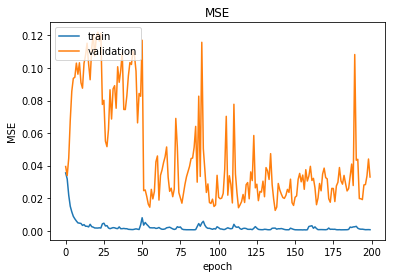

In [10]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

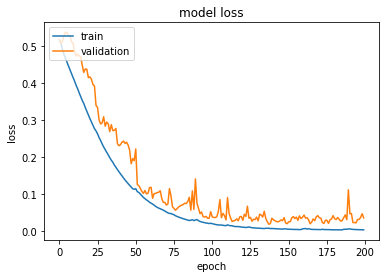

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
filepath="weight_troika_ori_2s.hdf5"
fir_model.load_weights(filepath)

In [13]:
#fir_model.summary()

In [14]:
#Evaluate
#eva = finalmodel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
#print('loss = ' + str(eva[0]))
#print('Test MSE = ' + str(eva[1]))

In [15]:
pred_label = fir_model.predict(X_train)

In [16]:
mod_model, y_mod_label = modify_model((1000, 5), y_train, pred_label, 16)

/media/zhuolun/DATA/Project/Atheros-CSI-Tool-UserSpace-APP/recvCSI/Xiaoshi/Xiong/augment  (1)/augment /modify_new.py:201: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  model = Model(input=inputs, output=output)


In [17]:
optm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
mod_model.compile(loss= "mse", 
              optimizer=optm, 
              metrics=["mse"])

In [18]:
filepath="weight_troika_ori_modify_2s.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = mod_model.fit(X_train, y_mod_label, 
                    epochs=100, 
                    batch_size=128, 
                    validation_split=0.2, 
                    callbacks=callbacks_list,
                    shuffle=True,
                    verbose=1)

Train on 5115 samples, validate on 1279 samples
Epoch 1/100
5115/5115 [==============================] - 11s 2ms/step - loss: 0.5896 - mean_squared_error: 0.0828 - val_loss: 0.5216 - val_mean_squared_error: 0.0166

Epoch 00001: val_mean_squared_error improved from inf to 0.01661, saving model to weight_troika_ori_modify_2s.hdf5
Epoch 2/100
5115/5115 [==============================] - 5s 1ms/step - loss: 0.5085 - mean_squared_error: 0.0061 - val_loss: 0.5131 - val_mean_squared_error: 0.0137

Epoch 00002: val_mean_squared_error improved from 0.01661 to 0.01374, saving model to weight_troika_ori_modify_2s.hdf5
Epoch 3/100
5115/5115 [==============================] - 5s 1ms/step - loss: 0.5014 - mean_squared_error: 0.0053 - val_loss: 0.5057 - val_mean_squared_error: 0.0133

Epoch 00003: val_mean_squared_error improved from 0.01374 to 0.01329, saving model to weight_troika_ori_modify_2s.hdf5
Epoch 4/100
5115/5115 [==============================] - 5s 1ms/step - loss: 0.4936 - mean_squared_e

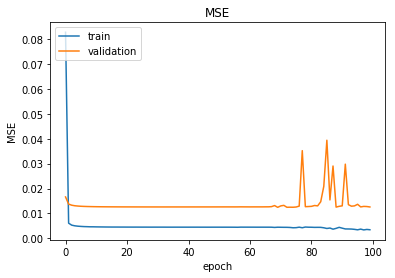

In [19]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

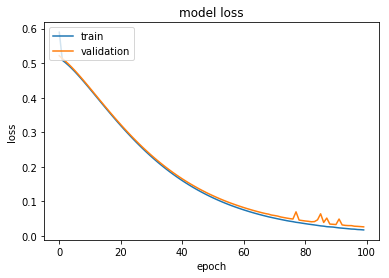

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
mod_model.load_weights('weight_troika_ori_modify_2s.hdf5')

In [22]:
predict = fir_model.predict(X_test)
predict_mod = mod_model.predict(X_test)

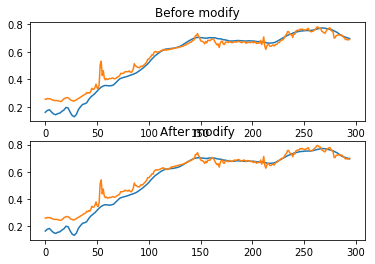

In [23]:
plt.subplot(211)
plt.plot(y_test)
plt.plot(predict)
plt.title('Before modify')
plt.subplot(212)
plt.plot(y_test)
plt.plot(predict+predict_mod)
plt.title('After modify')
plt.show()

In [24]:
Y_error = abs(y_test - (predict+predict_mod)) * 150
print('The avarage predict error: ', np.mean(Y_error))

The avarage predict error:  4.58520022002


In [25]:
Y_error = abs(y_test - predict) * 150
print('The avarage predict error: ', np.mean(Y_error))

The avarage predict error:  4.48244501303
